In [5]:
import pandas as pd
import os
import lxml.etree as et
import graphviz
from graphviz import Graph, Digraph

In [6]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [7]:
class Node:

    def __init__(self, name):
        self.name = name
        self.children = []

In [8]:
def get_raw_entities(root_elem):
    name = root_elem.tag.split('}')[1]
    children = list(root_elem)
    if len(children) != 0:
        attrs = [c.tag.split('}')[1] for c in children]
        if name not in entities:
            entities[name] = attrs
        for c in children:
            get_raw_entities(c)

In [9]:
def get_entities_from_xml():
    get_raw_entities(root[0])
    result = {key:values for key, values in entities.items() if not (key[-1] == 's' and key[:-1] in values)}
    return result

In [10]:
def add_child(parent, child):
    parent.children.append(child)

def translate(entity_name, current_node):
    for attr in entities[entity_name]:
        new_node = Node(attr)
        add_child(current_node, new_node)
        if attr in entities:
            dot.edge(current_node.name, f'{attr}')
            translate(attr, new_node)
        else:
            dot.edge(current_node.name, f'{entity_name[0:3]}_{attr}') # add prefix to node for uniqueness

In [11]:
def graft(parents, node):
    for p in parents:
        for child in entities[node]:
            entities[p].append(child)
        entities[p].remove(node)

In [12]:
def prune(parent, node):
    entities[parent].remove(node)

#### Read and parse .xml

In [13]:
path = r'fcsNotificationEA44_0119300019817000426_12490609.xml'
tree = et.parse(path)
root = tree.getroot()
entities = {}
entities_names = []
entities = get_entities_from_xml()

#### Build an atribute tree

In [14]:
multiple = ['customerRequirements', 'kladrPlaces', 'purchaseObjects', 'preferenses', 'requirements', 'attachments']
for k,v in entities.items():
    entities[k] = list(map(lambda x: x[:-1] if x in multiple else x, v))
entities['applicationGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['applicationGuarantee'])) 
entities['contractGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['contractGuarantee'])) 
graft(['purchaseObject'], 'customerQuantities')
graft(['customerQuantity'], 'quantity')
graft(['reason'], 'responsibleDecision')
graft(['attachment'], 'cryptoSigns')
graft(['kladrPlace'], 'kladr')
graft(['fcsNotificationEF'], 'printForm')
prune('purchaseObject', 'quantity')
prune('currency', 'code')
prune('fcsNotificationEF', 'id')
prune('placingWay', 'code')
prune('preferense', 'code')
prune('ETP', 'code')
prune('kladrPlace', 'kladrCode')
prune('attachment', 'publishedContentId')
prune('customerRequirement', 'purchaseCode')
prune('customerRequirement', 'tenderPlanInfo')

In [15]:
root = Node('fcsNotificationEF')
#dot = Graph(comment='Atribute tree', strict=True, engine='fdp')
dot = Digraph(comment='Atribute tree', strict=True, engine='fdp')
dot.attr(size='25,5')
translate('fcsNotificationEF', root)
dot.view() #to open .pdf

'Digraph.gv.pdf'

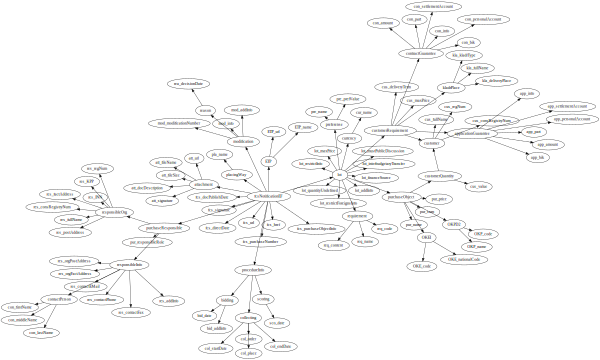

In [16]:
dot

#### Define measures and dimensions from DFM.pdf

In [84]:
class DfmNode:
    def __init__(self, dimensions, measures=[]):
        self.measures = measures
        self.dimensions = dimensions
        self.count_measures = []
        
    def merge_measures(self):
        self.measures.extend(self.count_measures)
        self.measures = list(set(self.measures))

In [85]:
dfm = {
    'lot': DfmNode(['financeSource', 'mustPublicDiscussion', 'Currency', 'interbudgetaryTransfer'],
                   ['quntityUndefined', 'maxPrice']),
    'fcsNotificationEF': DfmNode(['placingWay', 'lot', 'ETP', 'procedureInfo', 'purchaseResponsible', 'docPublishDate',
                                  'directDate', 'modification_reasonType', 'modification_decisionDate']),
    'preference': DfmNode(['lot']),
    'requirement': DfmNode(['lot']),
    'purchaseObject': DfmNode(['OKDP2', 'OKEI', 'lot'], ['sum', 'price']),
    'customerQuantity': DfmNode(['purchaseObject', 'customer'], ['value']),
    'customerRequirement': DfmNode(['customer', 'lot', ], ['maxPrice']),
    'kladrPlace': DfmNode(['customerRequirement', 'kladrType']),
    'contractGuarantee': DfmNode(['customerRequirement'], ['amount']),
    'applicationGuarantee': DfmNode(['customerRequirement'], ['amount']),
    'purchaseResponsible': DfmNode(['responsibleRole', 'responsibleInfo', 'responsobleOrg']),
    'responsibleInfo': DfmNode(['contactPerson']),
    'attachment': DfmNode(['fcsNotificationEF'], ['fileSize']),
    'procedureInfo': DfmNode(['collecting_startDate', 'collecting_endDate', 'bidding_date', 'scoring_date']),
    'customer': DfmNode([]),
}

#### Add count measure

In [86]:
def add_previous(name):
    for dim in dfm[name].dimensions:
        if dim in dfm:
            dfm[name].count_measures.extend([f'{name}/{m}' for m in dfm[dim].count_measures])
            add_previous(dim)

In [87]:
for key, value in dfm.items():
    dfm[key].count_measures.append(key + '_count')
    dfm[key].count_measures.extend([f'{key}/{dim}_count' for dim in value.dimensions])
    add_previous(key)
    dfm[key].merge_measures()

In [88]:
dfm['customerQuantity'].measures

['customerQuantity_count',
 'customerQuantity/purchaseObject/OKEI_count',
 'customerQuantity/purchaseObject/lot/mustPublicDiscussion_count',
 'customerQuantity/customer_count',
 'customerQuantity/purchaseObject/lot/interbudgetaryTransfer_count',
 'customerQuantity/purchaseObject/lot_count',
 'customerQuantity/purchaseObject/lot/financeSource_count',
 'customerQuantity/purchaseObject_count',
 'value',
 'customerQuantity/purchaseObject/OKDP2_count',
 'customerQuantity/purchaseObject/lot/Currency_count']

In [91]:
dfm['customerRequirement'].measures

['customerRequirement/lot/financeSource_count',
 'customerRequirement/lot_count',
 'customerRequirement/customer_count',
 'customerRequirement/lot/interbudgetaryTransfer_count',
 'customerRequirement_count',
 'maxPrice',
 'customerRequirement/lot/mustPublicDiscussion_count',
 'customerRequirement/lot/Currency_count']